In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbconvert
import pandoc

from pandas_datareader import fred
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import VECM

from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def adf_test_summary(ser):
    # ADF H0: there is a unit root

    specs = {'constant': 'c', 'constant trend': 'ct', 'constant ltend, qtrend': 'ctt', 'none': 'n'}
    results = {}

    for pretty, spec in specs.items():
        adf, pval, ulag, nobs, cval, icb = adfuller(ser, regression=spec)
        keys = ['adf-stat', 'p-value', '#lags', '#obs', *cval.keys(), 'inf crit']
        res = [adf, pval, ulag, nobs, *cval.values(), icb]
        results[pretty] = dict(zip(keys, res))

    if ser.name is not None:
        title = ser.name.upper()
    else:
        title = ''

    print('-' * 77)
    print(f'ADF Test {title}: H0 there is a unit root')
    print('-' * 77)
    print(pd.DataFrame(results).transpose().round(3).iloc[:, :-1])
    print('\n')

    pass


from io import StringIO
import sys


class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


def plot_df(df, n_cols: int = 3, fig_size: tuple = (5, 2)):
    n_cols = min(n_cols, df.shape[1])
    rows = int(np.ceil(df.shape[1] / n_cols))

    fig, axes = plt.subplots(rows, n_cols, figsize=(n_cols * fig_size[0], rows * fig_size[1]))
    for i, ax in enumerate(axes.reshape(-1)):
        if i > df.shape[1] - 1: continue
        ax.plot(df.iloc[:, i].dropna())
        ax.set_title(df.iloc[:, i].name)

    plt.tight_layout()
    return fig

# Part 1: The Present Value Model for Stock Fundamental Analysis

## Downloading the data

In [4]:
start, end = datetime(2000, 1, 1), datetime(2022, 12, 31)

In [5]:
reader = fred.FredReader(['TB3MS'], start, end)
data = reader.read()

data.rename(columns={
        'TB3MS': 'rf',
}, inplace=True)

In [6]:
str_tickers = ['IBM'] #, 'AAPL'] # 'XOM', 'IBM', ]

In [7]:
_ = yf.download(tickers = str_tickers, start=start, end=end)
_.index.name = 'date'

_ = pd.DataFrame(_['Adj Close'])
_.columns = [f'{c}_price' for c in str_tickers]

data = data.join(_, how='outer')

[*********************100%%**********************]  1 of 1 completed


In [8]:
tickers = [yf.Ticker(t) for t in str_tickers]

dividends = pd.DataFrame(index=pd.date_range(start, end))
for ticker in tickers:
    _ = pd.DataFrame(ticker.dividends.rename(f'{ticker.ticker}_div')).tz_convert(None)
    dividends = dividends.join(_, how='outer')
dividends = dividends.loc[start: end].dropna(thresh=1)

In [9]:
dividends = pd.DataFrame(dividends.values, index=[i.date() for i in dividends.index], columns=[f'{i}_div' for i in str_tickers])

In [10]:
data = data.join(dividends, how='outer')

<Axes: >

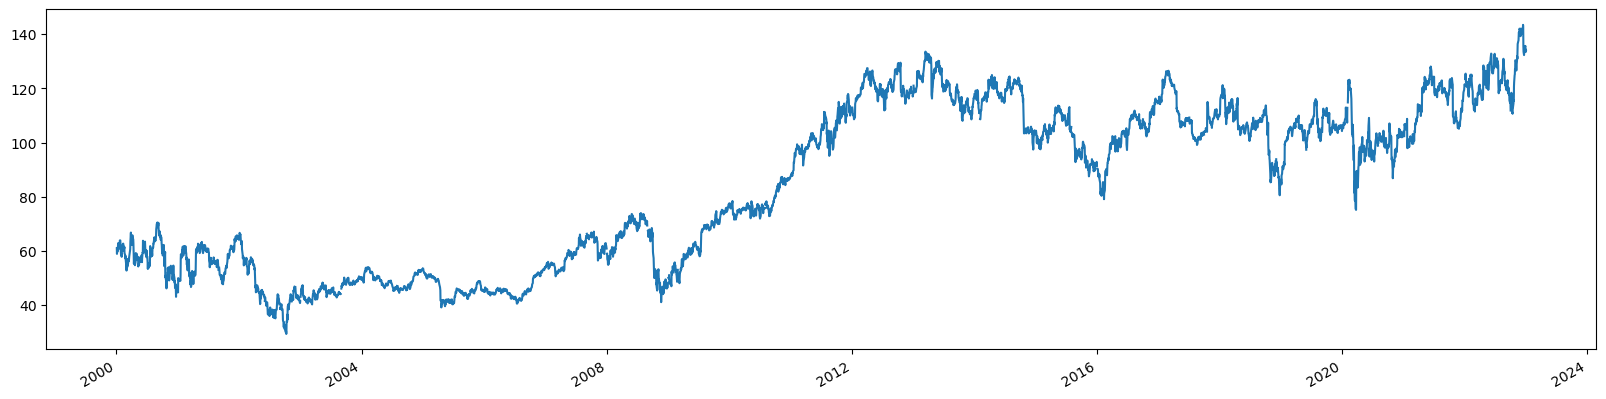

In [11]:
data.IBM_price.plot(figsize=(20, 5))

We consider the prices of the IBM stock from 2000 to late 2022 (FRED, 2023). Despite being recorded daily, the prices downloaded are quarterly averages so that the frequency matches with the dividend payment frequency, which is quarterly (Yahoo!Finance, 2023).

The plot above shows the evolution of the prices for IBM for the last 22 years. We chose this time period because it provides us with 92 observations over a period that is recent enough for the stock market to be similar enough that the results will not be biased by too many unobserved changes that occured especially in the 1990s.

Furthermore,  we wish to limit the sample so that we are not including too many crises into our time period and we do not expose ourselves to too many unobserved time-variant factors, like changes in financial attitudes or significant improvements in technology. However, in the following section where we consider the prediction of future returns with the identification of a fundamental value from the Gordon-Shapiro model we consider a longer period and an index of returns where the effect of a crisis is more likely to be reflected by the index and not, perhaps, passed by an individual stock.

## Naive stationarity validation

In [12]:
ols_data = data[[f'{str_tickers[0]}_price', f'{str_tickers[0]}_div']].dropna().copy()

Continuing with IBM's fundamental analysis, the equation
$$
IBMprice_t = β_0 + β_1 * IBMdiv_t + u_t
$$
is estimated using ordinary least squares. The results of the regression are presented below.

The residuals from this equation should be stationary. Price and dividends are cointegrated:
$$
P_t = \frac{D_t}{r - g}
$$
Assuming no growth in the dividend rate, the above equation is reflected by the regression below if we introduce stationary time series $u_t$ of the value of the residuals from the model.

Hence we have
$$
P_t = \frac{1}{r} D_t + u_t
$$

We cam evaluate the validity of this relationship following the estimation by plotting the residuals and testing for stationarity.

In [13]:
ols = OLS(ols_data.iloc[:, 0], ols_data.iloc[:, 1]).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:              IBM_price   R-squared (uncentered):                   0.871
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              613.6
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                    3.20e-42
Time:                        18:38:05   Log-Likelihood:                         -449.43
No. Observations:                  92   AIC:                                      900.9
Df Residuals:                      91   BIC:                                      903.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Axes: >

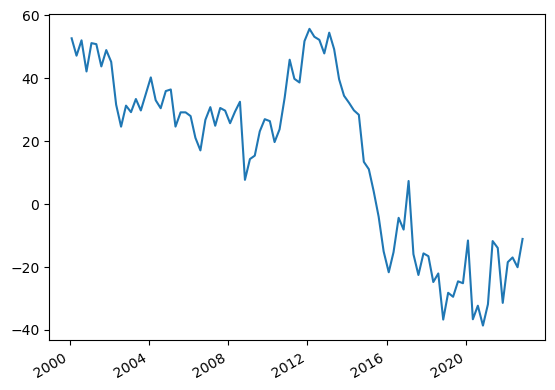

In [14]:
ols.resid.plot()

In [15]:
adf_test_summary(ols.resid)

-----------------------------------------------------------------------------
ADF Test : H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  #lags  #obs     1%     5%    10%
constant                  -1.411    0.577    8.0  83.0 -3.512 -2.897 -2.586
constant trend            -2.231    0.473    8.0  83.0 -4.072 -3.465 -3.159
constant ltend, qtrend    -2.514    0.561    8.0  83.0 -4.517 -3.906 -3.598
none                      -1.586    0.106    8.0  83.0 -2.593 -1.945 -1.614




The time series $u_t$ clearly exhibits characteristics of a unit root and the augmented Dickey-Fuller fails to reject the null hypothesis of a unit root. The relationship $P_t = \frac{D_t}{r} + u_t$ where $u_t$ is a stationary error term is of course rejected so we move towards the Vector Error Correction Model. The vector error correction model is used when there is cointegration between the variables. The 'error correction' is because last period's deviation from the long-run equilibrium price, which is the error or residual, influences the dynamics of the price evolution. To avoid ignoring potentially important long-run relationships between the variables the I(1) variables are not differenced to induce stationarity and to allow estimation of a VAR.

## Vector Error Correction Model

A way other than differencing to eliminate a trend for I(1) non-stationary variables is to compute $Y_t - θX_t$ if $Y_t$ and $X_t$ are cointegrated. $θ$ eliminates the common trend from the difference and because $Y_t - θX_t$ is stationary, it can be used in a VAR.

The VECM estimated is therefore of the form
$$
ΔP_t = β_{10} + β_{11}ΔP_{t-1} + ... + β_{1p}ΔP_{t-p} + γ_{1p}ΔD_{t-1} + ... + γ_{1p}ΔD_{t-p} + α_1(Y_{t-1} - θD_{t-1}) + u_{1t}
$$
and 
$$
ΔD_t = β_{20} + β_{21}ΔD_{t-1} + ... + β_{2p}ΔD_{t-p} + γ_{2p}ΔP_{t-1} + ... + γ_{2p}ΔP_{t-p} + α_2(Y_{t-1} - θD_{t-1}) + u_{2t}
$$

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank, select_order

$$ y_t = Πy_{t−k} + Γ_1Δy_{t-1} + Γ_2Δy_{t-2} + ... + Γ_{k-1}Δy_{t-(k-1)} + u_t $$

with $Π = Σ^k_{i=1}β_i$

This is matrix form of the equation outlined above, where $y_t$ contains 2 variables in the first differenced form (Tsay, 2005). Π is the long-run coefficient matrix because in the equilibrium, the differenced variables are all 0. The test for cointegration of the variables $P_t$ and $D_t$ is conducted by looking at the rank of the Π coefficient matrix and its eigenvalues (Brooks, 2019). The rank of the matrix is the number of eigenvalues that are different from 0. The eigenvalues, denoted λ, are put in ascending order and if they are roots they must be less than 1 in absolute value but positive. $λ_1$ will be the largest all the way to $λ_g$ which is the smallest.

If the rank is 1, $ln(1-λ_1)$ will be negative and $ln(1-λ_i) = 0\forall i$.

The 'trace' approach that follows in this analysis uses the test-statistic 
$$
λ_{trace}(r) = -TΣ_{i=r+1}^g ln(1-\hat{λ_i})
$$
where r is the number of cointegrating vectors under the null. $λ_{trace}$ is a joint test where the null, $H_0$:number of cointegrating vectors is less than or equal to r where the alternative is larger than or equal to r. This means it is a test that starts with p eigenvalues and the largest is removed until the eigenvalues are equal to 0 and the indication of the cointegrating relationships have been exhausted (Brooks, 2019).

### Cointegration Testing

In [17]:
jrank = select_coint_rank(ols_data, 1, 10, signif=.05)
jrank.summary()

r_0,r_1,test statistic,critical value
0,2,18.50,18.40
1,2,4.047,3.841


There are only two variables and the eigenvalues are significantly different from 0 in both cases, this means that there is a cointegrating relationship between $P_t$ and $D_t$. An error correction term therefore exists and the data is therefore suitable for estimation of the vector error correction model.

In [18]:
vecm_data = data[[f'{str_tickers[0]}_price', f'{str_tickers[0]}_div']].dropna().copy()
# vecm_data = vecm_data.asfreq('D')
vecm_data.columns = ['price', 'div']

In [19]:
# financial crisis structural break

### Specification of Structural Breaks

The financial crisis is identified as a structural break and a dummy variable is employed for years 2008 and 2009 to indicate this and prevent endogeneity.

In [20]:
vecm_data['is_fcrisis'] = [i.year in [2008, 2009] for i in vecm_data.index]

In [21]:
# select var lag order
# order 4 as according to BIC and HQIC

### VECM Order Selection

In [22]:
var_order = select_order(vecm_data[['price', 'div']].values, maxlags=10, deterministic='ci')
var_order.summary()

,AIC,BIC,FPE,HQIC
0,-2.139,-1.903,0.1178,-2.044
1,-2.121,-1.766,0.1200,-1.978
2,-2.219,-1.746,0.1089,-2.029
3,-2.395,-1.804,0.09143,-2.158
4,-3.218,-2.509*,0.04020,-2.934*
5,-3.147,-2.319,0.04328,-2.815
6,-3.216,-2.270,0.04052,-2.837
7,-3.255,-2.191,0.03916,-2.828
8,-3.272*,-2.090,0.03873*,-2.798
9,-3.186,-1.885,0.04250,-2.664


BIC is a general approach to model selection that favours more parsimonious models over more complex models that would be specified by the Akaike's information criterion, for example. The Bayesian Information Criterion adds a penalty based on the number of parameters being estimated and is more trusted against overidentification. The number of lags chosen is 4 as reccomended by the BIC and Hannan-Quinn Information Criterion.

In [23]:
jtest = select_coint_rank(vecm_data[['price', 'div']], 0, 3, method="trace", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          16.89          15.49
  1   2         0.6717          3.841
-------------------------------------


1

In [24]:
vecm = VECM(vecm_data[['price', 'div']], exog=vecm_data.is_fcrisis, k_ar_diff=2, coint_rank=jtest.rank).fit()
print(vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation price
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1          1.0530      2.873      0.367      0.714      -4.578       6.684
L1.price      -0.1986      0.104     -1.908      0.056      -0.403       0.005
L1.div        -7.7767     23.150     -0.336      0.737     -53.149      37.596
L2.price      -0.2030      0.104     -1.954      0.051      -0.407       0.001
L2.div       -42.0675     23.183     -1.815      0.070     -87.506       3.371
Det. terms outside the coint. relation & lagged endog. parameters for equation div
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1          0.0064      0.013      0.508      0.612      -0.018       0.031
L1.price       0.0001      0.000      0.30

The VECM is estimated as:
$$
[\begin{matrix} ΔP_t \\ ΔD_t \end{matrix}] = [\begin{matrix} -0.1986 & -7.7767\\-0.2030 & - 42.0675 \end{matrix}][\begin{matrix} ΔP_{t-1} \\ ΔD_{t-1} \end{matrix}] + [\begin{matrix} 1.0530 \\ 0.0064 \end{matrix}] FC_t + [\begin{matrix}ε_{1t}\\ε_{2t} \end{matrix}]
$$



$$
ΔD_t = [\begin{matrix} -0.0001 & -0.3052\\-0.0004 & -0.2888 \end{matrix}][\begin{matrix} ΔP_{t-1} \\ ΔD_{t-1} \end{matrix}] + [\begin{matrix}0.0256 \\ 0.0005\end{matrix}]EC_1 + ε_{3t}
$$

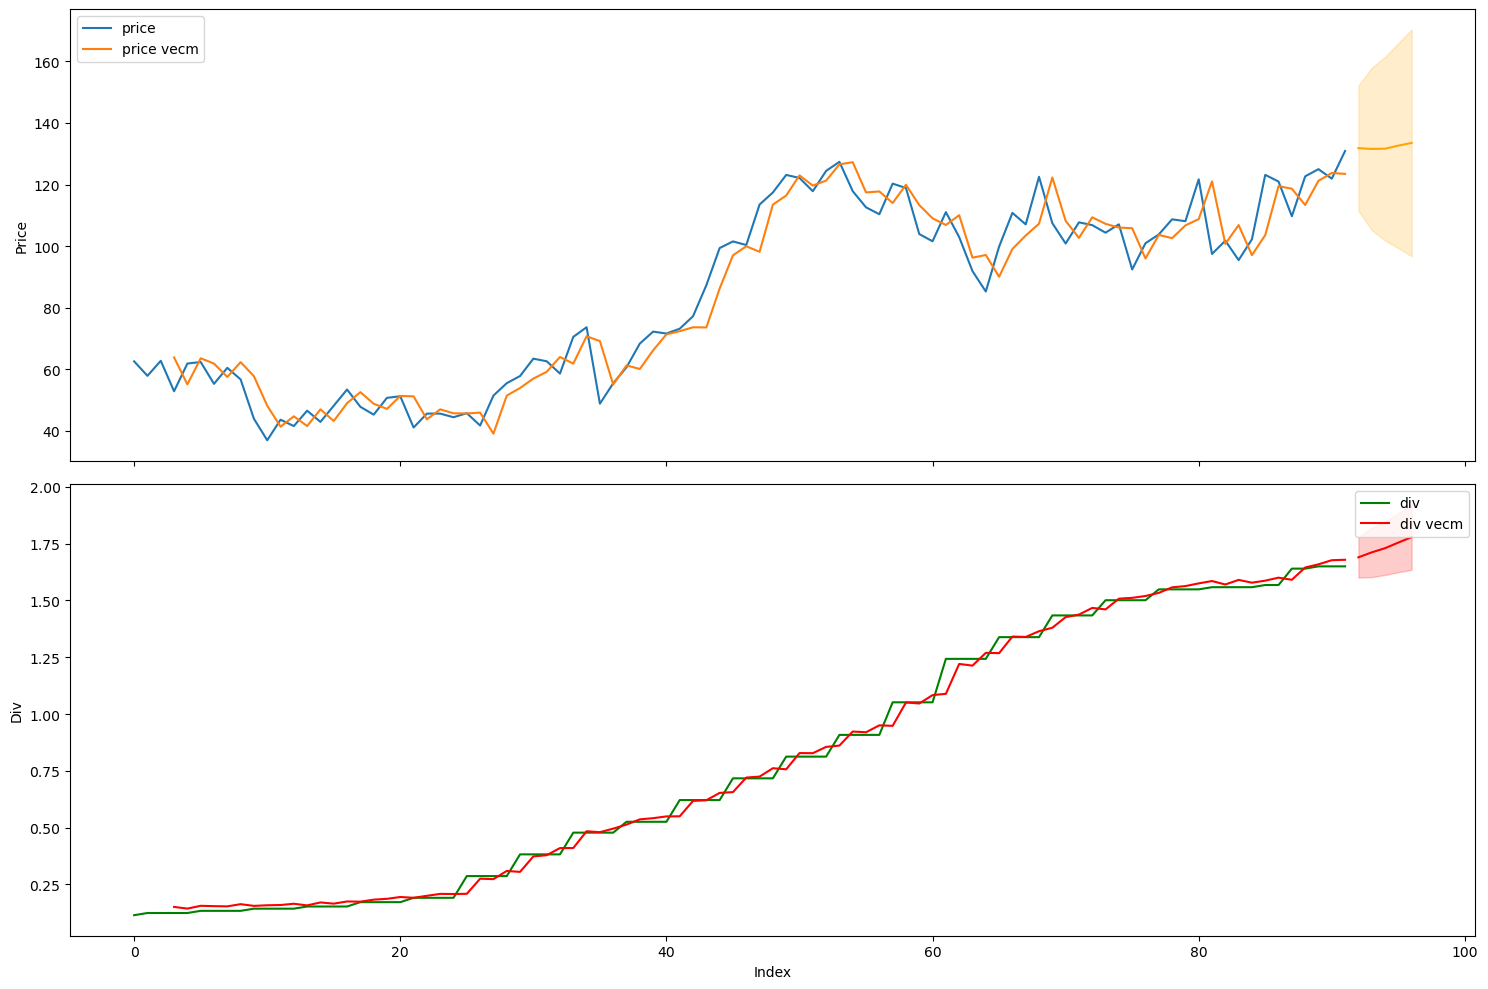

In [25]:
pred_steps = 5
pred, lower, upper = vecm.predict(pred_steps, alpha=.01, exog_fc=np.array([False] * pred_steps))
index = [*range(0, vecm_data.shape[0] + pred_steps)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

ax1.plot(index[:-pred_steps], vecm_data.iloc[:, 0].values, label='price')
ax1.plot(index[vecm.k_ar:-pred_steps], vecm.fittedvalues[:, 0], label='price vecm')
ax1.plot(index[-pred_steps:], pred[:, 0], color='orange')
ax1.fill_between(index[-pred_steps:], lower[:, 0], upper[:, 0], alpha=.2, color='orange')

ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

ax2.plot(index[:-pred_steps], vecm_data.iloc[:, 1].values, label='div', color='green')
ax2.plot(index[vecm.k_ar:-pred_steps], vecm.fittedvalues[:, 1], label='div vecm', color='red')
ax2.plot(index[-pred_steps:], pred[:, 1], color='red')
ax2.fill_between(index[-pred_steps:], lower[:, 1], upper[:, 1], alpha=.2, color='red')

ax2.set_xlabel('Index')
ax2.set_ylabel('Div')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

This plot reflects the accuracy of the VECM at estimating price and dividends for IBM over our sample period. In other words, it shows how effectively the model can fit the actual observations. The model is effective, but is slightly lagged at reflecting the shocks to the price of the IBM stock. The impulse response functions below show in greater detail how each variable reflects to a shock.

Dividends are better predicted than price. Both plots follow each other closely but again the VECM-predicted dividend is lagged slightly.

### Impulse Response Functions

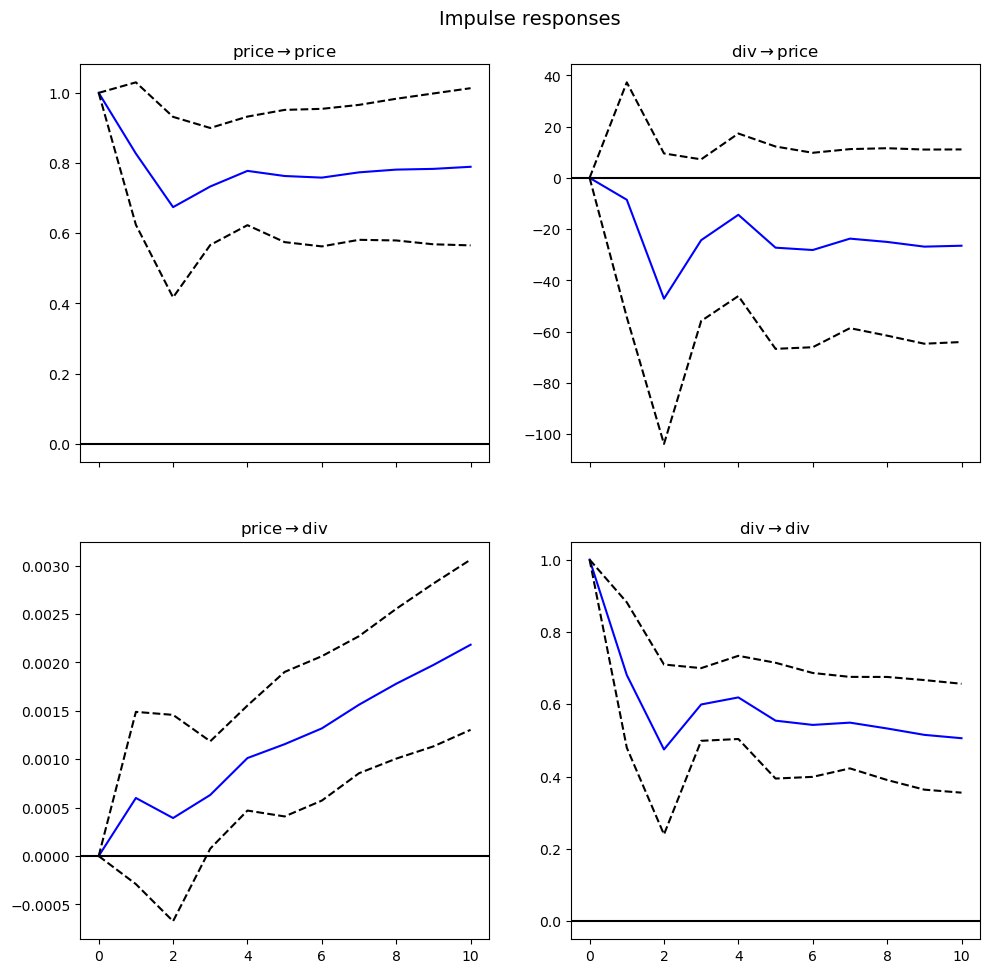

In [26]:
vecm.irf().plot();

The dynamic dependence of a shock on price is high. The price shows a sharp decay initially but the shock persists over time. A shock on price affects dividends as well. As seen by the figure in the bottom left quadrant, the positive and lasting increase in shareprice has a positive and lasting effect on dividends. Dividends increase with persistence after a shock on price. 

A shock to only dividends is less clear-cut. Dividends show a sharper decline following the shock but still persist showing dynamic dependence which is exhibited in the VECM equation. The coefficient in the first of $ΔD_t$ to $ΔD_{t-1}$ is -42.0675. Given the shock is instantaneous the initial decline is rapid but this eventually slows as dividends reach an equilibrium. The effect of a dividend shock on price follows a similar patter with price quickly declining as dividends fall following the shock but also levelling out shortly after.


### Post-Estimation Tests

#### Granger Causality Test

In [27]:
granger_results = vecm.test_granger_causality(caused="price", signif=0.05)
print(granger_results.summary())

Granger causality F-test. H_0: div does not Granger-cause price. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.184          2.662   0.318 (3, 158)
----------------------------------------------


The Granger causality test tests whether a time series is fruitful in predicting another. The null hypothesis is an absence of causality for dividends on price. The p-value is large so we cannot reject the null hypothesis and we accept the null: Dividends exert granger causality on price. A rejection of the null hypothesis would be a worrying conclusion for any analyst.

#### White Test

In [28]:
white_test = vecm.test_whiteness(nlags=12, adjusted=True)
print(white_test.summary())

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         166.4          53.38   0.000 38
----------------------------------------


The White test is a test that examines whether there is constant variance in the errors: whether they are homoskedastic. The White test rejects the null that there is no autocorrelation in the VECM residuals. The residual's autocorrelogram is plotted below.

### Autocorrelation Functions

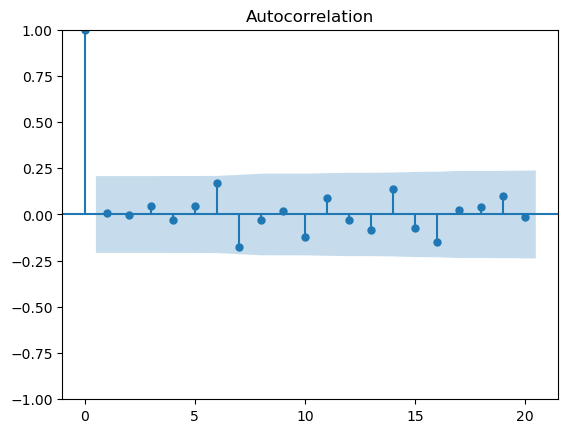

In [29]:
plot_acf(vecm.resid[:, 0]);

The autocorrelation of the errors are non-zero but not large and statistically insignificant suggesting correct specification of the model.

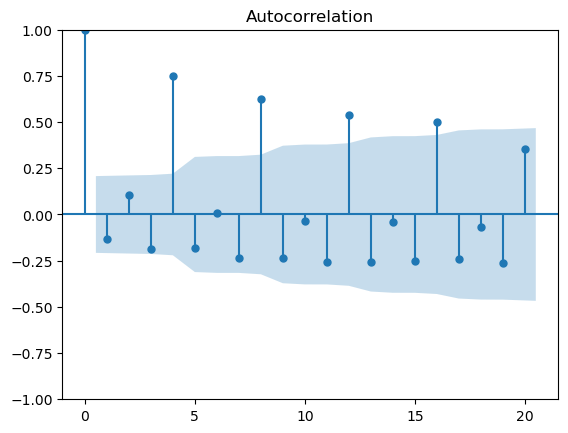

In [30]:
plot_acf(vecm.resid[:, 1]);

# Part 2: Gordon-Shaprio Model Fundamental Analysis

Now that we have considered the present value model and the Vector Error Correcting Mechanisms that follow, we can now turn to the analysis we have seen in class: Prediction of future returns with the identification of a fundamental value.

Usually the reference value of a stock is the hirotical mean of its past values. In this case past values of IBM, but the series of IBM's stock price has a unit root (non-stationarity) and so the presence of a mean-reverting mechanism is rejected.

We have checked that both series of $p_t$ and $d_t$ are integrated of order 1 by implementing the Dickey-Fuller unit root test, which test the null hypothesis $H_0$: there is a unit root. In both cases we cannot reject this null hypothesis.

Now, we look for cointegrating relationships.

Recall the present value model: 
$$
P_t = \frac{D_t}{r_t^e - g_t^e} $$

Where $r_t^e$ is the expected rate of return which is now considered to be a discount rate ($ = r_{Ft} + π_t^e$) and $g_t^e$ is the expected growth rate of dividends. 

Hence we have
$$
P_t = \frac{D_t}{r_{Ft} + π^a_t-g_t^e} 
$$
Defining $Z_t$ as a weakly stationary process which does not deviate from its mean of 0 over the long time, the three processes $log(P_t)_t , (logD_t)_t$ and $ r_{Ft}$ are cointegrated and the time series exhibit correlation in the long-term.

$$
logP_t - logD_t - log(r_{Ft} + π^a_t - g^a_t) = Z_t
$$

If the ratio $ \frac{r_{Ft} + π^a_t - g^a_t - r_0}{r_0}$ is small compared to 1, where $r_0$ is the historical mean rate of return of the stock:
$
log(\frac{r_{Ft} + π^a_t - g^a_t - r_0}{r_0} + 1)$ ~ $\frac{r_{Ft} + π^a_t - g^a_t - r_0}{r_0}
$

The unobserved variables $π_t^e - g_t^e$ result from expectations that evolve over time, and is assumed to be constant except for some infrequent changes.

The variable $π_t^e - g_t^e$ is specified as following:
$$
π_t^e - g_t^e = Σ^K_{k=1}γ_k1_{t≥τ_k}
$$

where $ 1_{t≥τ_k} = 1$ if $t≥τ_k$ and 0 otherwise. The breaks induced in the cointegration relationship proxy the unobserved variable $π_t^e - g_t^e$.

Estimation of the series Z continues below.

## Choice of Time Series, Dates and Frequency

We follow closely the analysis in class and use NASDAQ100 (https://fred.stlouisfed.org/series/NASDAQ100), 10-year long-term government bond yields as the long-term interest rate (https://fred.stlouisfed.org/series/IRLTLT01USM156N) and the United State's real GDP (https://fred.stlouisfed.org/series/GDPC1). The data is quarterly for macroeconomic variables, so the NASDAQ100 index price is averaged over each quarter. The data ranges from 1981-01-01 to 2023-07-01: 151 observations.

For this analysis, we extended the sample period because our observations were quarterly and more infrequent. This required us to specify more dummy variables for financial crises, and we used the indications in the course material to do this as can be seen below. The selection of the NASDAQ100 was motivated by the availability of historical data ensuring as many observations as possible while not using an index that was too economy-wide like the Wishire5000 that may lead us to suffer from collinearity with GDP later on.

In [31]:
file_path = "/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Asset Pricing/Projec/AP2/FRED.csv"

In [32]:
data2 = pd.read_csv("/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Asset Pricing/Projec/AP2/FRED.csv")

In [33]:
data2 = data2.rename(columns={"DATE": "Date"})
data2["Date"] = pd.to_datetime(data2["Date"])
data2 = data2.set_index("Date")
data2 = data2[data2.index >= "1986-01-01"]

In [34]:
data2 = data2.rename(columns={"DATE": "Date", "GDPC1": "gdp", "IRLTLT01USM156N": "ir", "NASDAQ100": "sp"})

In [35]:
numeric_columns = ["gdp", "ir", "sp"]
data2[numeric_columns] = data2[numeric_columns].apply(pd.to_numeric, errors='coerce')


datalog = pd.DataFrame()
datalog["lgdp"] = np.log(data2["gdp"].replace(0, np.nan))  # Replace 0 with NaN before applying log
datalog["lsp"] = np.log(data2["sp"].replace(0, np.nan))
datalog["lir"] = np.log(data2["ir"].replace(0, np.nan))# Replace 0 with NaN before applying log
datalog['ir'] = data2['ir']

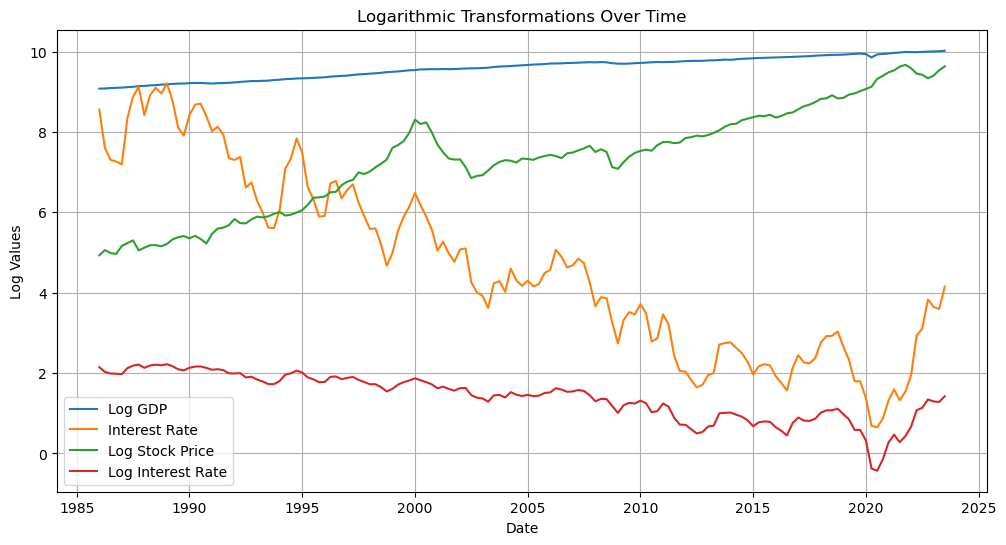

In [36]:
plt.figure(figsize=(12, 6))

plt.plot(datalog.index, datalog['lgdp'], label='Log GDP')
plt.plot(datalog.index, datalog['ir'], label='Interest Rate')
plt.plot(datalog.index, datalog['lsp'], label='Log Stock Price')
plt.plot(datalog.index, datalog['lir'], label='Log Interest Rate')

plt.title('Logarithmic Transformations Over Time')
plt.xlabel('Date')
plt.ylabel('Log Values')
plt.legend()
plt.grid(True)
plt.show()

The 1987 crisis is the black monday stock market crash. We set the dummy variable DUM1987Q4 equal to zero for all dates before quarter four 1987 and equal to one for all dates on and after this time to indicate a structural change. The 2002 financial crisis is the stockmarket downturn in mid-2002. The 2008 crisis needs no introduction and is included for obvious reasons, beginning in quarter 4 with the collapse of Lehman Brothers. And the 2020 crisis is to indicate the structural change that was COVID-19.

In [37]:
datalog['DUM1987Q4'] = (datalog.index >= '1987-10-01').astype(int)
datalog['DUM2002Q3'] = (datalog.index >= '2002-07-01').astype(int)
datalog['DUM2008Q4'] = (datalog.index >= '2008-10-01').astype(int)
datalog['DUM2020Q1'] = (datalog.index >= '2020-01-01').astype(int)

In [38]:
datalog = datalog.drop('2023-10-01', errors='ignore')

## Estimation of Z
The series $Z_t$ can be estimated as
$$
Z = lsp - (β_0 + β_1DUM1987Q4 + β_2DUM2002Q3 + β_3DUM2008Q4 + β_4DUM2020Q1 + β_5lgdp) + β_6ir
$$

This model is estimated using OLS.

In [39]:
regression_data = datalog[['lgdp', 'ir', 'lsp', 'DUM1987Q4', 'DUM2002Q3', 'DUM2008Q4', 'DUM2020Q1']]

regression_data['const'] = 1

model = sm.OLS(regression_data['lsp'], regression_data[['const', 'lgdp', 'ir', 'DUM1987Q4', 'DUM2002Q3', 'DUM2008Q4', 'DUM2020Q1']])
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    lsp   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          1.41e-122
Time:                        18:38:16   Log-Likelihood:                 49.264
No. Observations:                 151   AIC:                            -84.53
Df Residuals:                     144   BIC:                            -63.41
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -51.0587      1.814    -28.147      0.0

Z is therefore estimated as:
$$
Z = ln(NASDAQ100) - (-51.0587 + 6.2101ln(GDP) -0.3375DUM1987Q4 - 1.1577DUM2002Q3 -0.1187DUM2008Q4 +0.2975DUM2020Q1 - 0.0443ir)
$$

This estimation is imperfect. The signs on the crisis indicators are mostly what we would expect. As seen in class, the signs estimated for the crisis dummies should be negative, and indeed they are except for the 2020 crisis. Additionally, we expect a positive coefficient for $ln(GDP)$ which we get. But the value is a long way from the expected value of 1. Furthermore, the coefficient on the long-term interest rate is negative as in the model estimated in class for FTSE100. Ultimately, the log-value of the NASDAQ100 stock index is thus estimated as:

$$
p^* = -51.0587 + 6.2101ln(GDP) -0.3375DUM1987Q4 - 1.1577DUM2002Q3 -0.1187DUM2008Q4 +0.2975DUM2020Q1 - 0.0443ir
$$


The deviation of $Z_{t-1}$ from the fundamental log price, $p^*$ estimated above contributes to an error correction mechanism estimated below. 

If $Z_{t-1}>0$, the index is overvalued. The error correction mechanism should contribute to a decrease in the change in $ln(NASDAQ100)$ and induce a return of the stock index to its fundamental value, $p^*$.



## Cointegration Testing
### Johansen Cointegration Test

We begin with the Johansen Trace Test which we also employed in Part 1. It is a joint test where the null, $H_0$:number of cointegrating vectors is less than or equal to r where the alternative is larger than or equal to r.

In [48]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

variables = datalog[['lgdp', 'lsp', 'ir', 'DUM1987Q4', 'DUM2002Q3', 'DUM2008Q4', 'DUM2020Q1']]


result = coint_johansen(variables, det_order=0, k_ar_diff=1)


print("Eigenvalues:", result.eig)
print("Trace Statistics:", result.lr1)
print("Max Eigenvalue Statistics:", result.lr2)
print("Critical Values (90%):", result.cvt)
print("Critical Values (95%):", result.cvm)


print("Cointegrating Vectors:")
for i in range(len(result.eig)):
    print(result.evec[:, i] / result.evec[0, i])


Eigenvalues: [3.30700455e-01 1.98455116e-01 1.73333350e-01 6.79388744e-02
 3.96252516e-02 2.83694876e-02 1.45273745e-04]
Trace Statistics: [1.41967971e+02 8.21409595e+01 4.91800276e+01 2.08173191e+01
 1.03341439e+01 4.30981939e+00 2.16473605e-02]
Max Eigenvalue Statistics: [5.98270116e+01 3.29609319e+01 2.83627085e+01 1.04831753e+01
 6.02432447e+00 4.28817203e+00 2.16473605e-02]
Critical Values (90%): [[120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]
Critical Values (95%): [[43.2947 46.2299 52.3069]
 [37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
Cointegrating Vectors:
[ 1.         -0.12701921  0.02667406 -0.05471379 -0.12857435  0.03141466
 -0.06212405]
[ 1.00000000e+00 -1.73346416e-01 -3.34857401e-02 -3.09688868e

In [41]:
print("Trace Statistics:")
print(result.lr1)

print("\nCritical Values (90%):")
print(result.cvt[:, 0])  # Values for 90% confidence level

print("\nCritical Values (95%):")
print(result.cvt[:, 1])  # Values for 95% confidence level

# Similarly, you can access and print the max eigenvalue statistics and critical values
print("\nMax Eigenvalue Statistics:")
print(result.lr2)

print("\nCritical Values (90%):")
print(result.cvm[:, 0])  # Values for 90% confidence level

print("\nCritical Values (95%):")
print(result.cvm[:, 1])  # Values for 95% confidence level


Trace Statistics:
[1.41967971e+02 8.21409595e+01 4.91800276e+01 2.08173191e+01
 1.03341439e+01 4.30981939e+00 2.16473605e-02]

Critical Values (90%):
[120.3673  91.109   65.8202  44.4929  27.0669  13.4294   2.7055]

Critical Values (95%):
[125.6185  95.7542  69.8189  47.8545  29.7961  15.4943   3.8415]

Max Eigenvalue Statistics:
[5.98270116e+01 3.29609319e+01 2.83627085e+01 1.04831753e+01
 6.02432447e+00 4.28817203e+00 2.16473605e-02]

Critical Values (90%):
[43.2947 37.2786 31.2379 25.1236 18.8928 12.2971  2.7055]

Critical Values (95%):
[46.2299 40.0763 33.8777 27.5858 21.1314 14.2639  3.8415]


The max eigenvalue test indcates 2 cointegrating equations at the 95% level. The trace test also indicates 2 cointegrating vectors.

### Engle-Granger 2-step Method

The Engle-Granger 2-step method is slightly more long-winded. This method estimates an ordinary regression of the variables, and then assesses the residuals for a unit root. Presence of a cointegrating relationship should yield stationary residuals following this regression.

The table below is the OLS regression of $lsp$ on $lgdp$, the interest rate, a constant and the structural break dummies.

In [42]:
regression_data = datalog[['lgdp', 'ir', 'lsp', 'DUM1987Q4', 'DUM2002Q3', 'DUM2008Q4', 'DUM2020Q1']]

regression_data['const'] = 1

model = sm.OLS(regression_data['lsp'], regression_data[['const', 'lgdp', 'ir', 'DUM1987Q4', 'DUM2002Q3', 'DUM2008Q4', 'DUM2020Q1']])
result = model.fit()


print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    lsp   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          1.41e-122
Time:                        18:38:18   Log-Likelihood:                 49.264
No. Observations:                 151   AIC:                            -84.53
Df Residuals:                     144   BIC:                            -63.41
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -51.0587      1.814    -28.147      0.0

In [43]:
residuals = result.resid

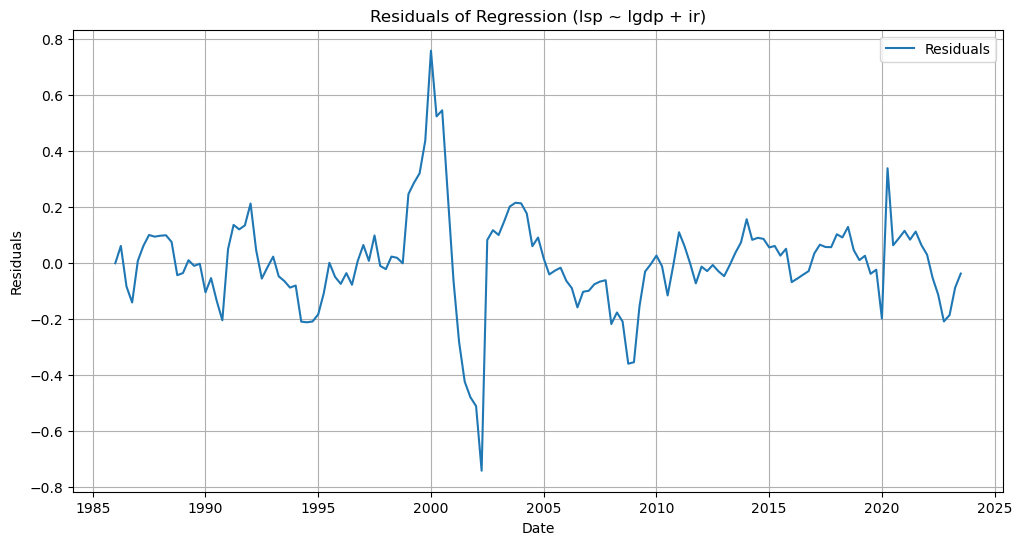

ADF Test Results on Residuals:
Test Statistic: -6.117697086949318
p-value: 9.011058180103705e-08
Critical Values: {'1%': -3.4759527332353084, '5%': -2.881548071241103, '10%': -2.577438765246763}
reject null hypothesis, suggesting stationarity


In [44]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of Regression (lsp ~ lgdp + ir)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

adf_result = sm.tsa.adfuller(residuals, maxlag=12)
print("ADF Test Results on Residuals:")
print(f'Test Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:', adf_result[4])
print('reject null hypothesis, suggesting stationarity' if adf_result[1] <= 0.05 else 'fail to reject null hypothesis, suggesting non-stationarity and the presence of a unit root')

Indeed, visual examination and performing the Augmented-Dickey Fuller test on the residuals leads us to accept the hypothesis that the residuals are stationary and there is a cointegrating relationship between lgdp, lsp and ir. In other words, these series exhibit similar long-term trends.

## VECM model

We now turn to estimation of vector error correction model as in Part 1. Specification is similar, but this time we employ three variables: $lsp$, $lgdp$ and $ir$ which is the log of the index's price, the log of GDP for the US and the long-term interest rate (or risk-free rate) in the US.

As mentioned above, there should be presence of an error correction mechanism to bring ant over/under valuation in the index's price back to its equilibrium value. This is justification of the existence of a long-term equation to destribe the equilibrium price with the strucutral breaks as specified in the previous section.

In [45]:
vecm = VECM(datalog[['lsp', 'lgdp', 'ir']], exog=datalog[['DUM1987Q4', 'DUM2002Q3', 'DUM2008Q4', 'DUM2020Q1']], k_ar_diff=2, coint_rank=jtest.rank).fit()
print(vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation lsp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1         -0.0413      0.027     -1.514      0.130      -0.095       0.012
exog2         -0.0550      0.029     -1.896      0.058      -0.112       0.002
exog3         -0.0181      0.026     -0.698      0.485      -0.069       0.033
exog4          0.0299      0.029      1.037      0.300      -0.027       0.087
L1.lsp         0.3200      0.081      3.933      0.000       0.161       0.479
L1.lgdp       -0.1068      0.765     -0.140      0.889      -1.606       1.392
L1.ir         -0.0365      0.022     -1.659      0.097      -0.080       0.007
L2.lsp         0.0456      0.084      0.546      0.585      -0.118       0.209
L2.lgdp       -0.4961      0.759     -0.654      0.513      -1.984       0.992
L2.ir          0.0337      0.023      1.461     

For the log of the price of the NASDAQ100 index, the coefficient for the error correction term is significant at the 99% confidence level, indicating that there exists an error correction relationship in the evolution of the price of the NASDAQ100 and the price returns to an equilibrium value which is suggested by the linear regression above. A VECM involving so many exogenous variables and with two lags yields a fairly extensive output table which we will make available in the appendix.

### Autocorrelation Function

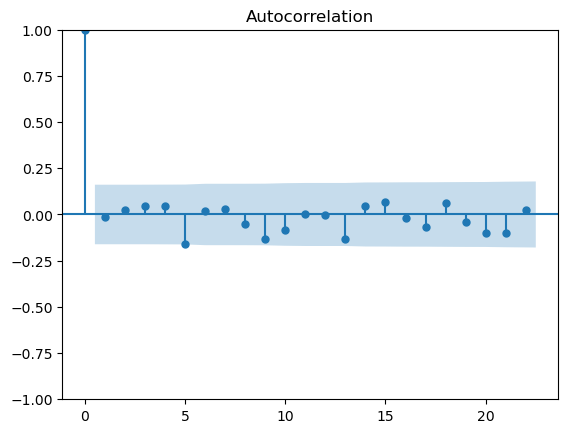

In [46]:
plot_acf(vecm.resid[:, 0]);

We observe small and statistically insignificant serial correlation for the residual of the equation of NASDAQ100 (lsp) suggesting the model is correctly specified.

### Impulse Response Functions

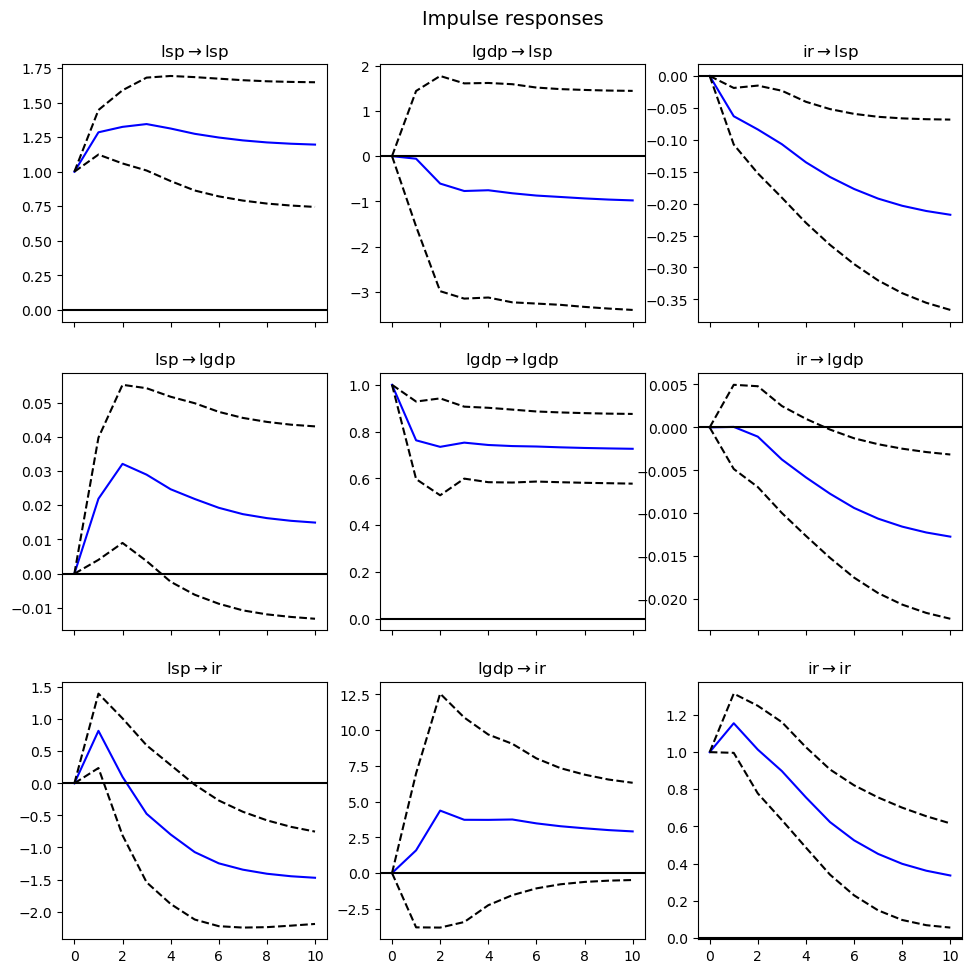

In [47]:
irf = vecm.irf()
x = irf.plot()

The impulse response functions for this VECM are similar to those in Part 1. 

Recall:
$$
Z = ln(NASDAQ100) - (-51.0587 + 6.2101ln(GDP) -0.3375DUM1987Q4 - 1.1577DUM2002Q3 -0.1187DUM2008Q4 +0.2975DUM2020Q1 - 0.0443ir)
$$

For a shock to log GDP, stock price has a small delayed, and negative reaction. This is because a positive shock in GDP will cause Z to be negative. Z being negative indicates the index is undervalued and the price should increase. However, the reaction to the increase in log GDP is absorped by the increase in the interest rate which cancels out the overvaluation. The log stock index price is affected negatively and exhibits a decline after a delay before levelling out.

For a shock in the interest rate, the interest rate slowly declines back to equilibrium. GDP is affected negatively and declines following the shock. The price of the NASDAQ100 follows the same trend.

When a shock is exerted on the log stock index price, the velocity of the shock causes lsp to continue to decrease before levelling off after 2 quarters and begin to decay, evidence of an error correcting process. GDP follows the same trajectory after a shock to the index price, increasing sharply and decaying after period 2. The effect on the interest rate is more interesting. The interest rate increases sharply as well, before declining into the negatives and levelling off at around period 8.

# Conclusion

Overall, throughout this assignment we have conducted two fundamental analyses. First, using the present value model we showed how the relationship between price and dividends, taking into account the return rate, does not yield stationary residuals. The error correcting mechanism is required to be estimated. The error correction model was estimated and the tests following showed integrity in the estimation.

In Part 2, we followed more closely the work covered in the class and the materials provided on the epi. We estimated the long-run equilibrium price based on fundamental macroeconomic variables while allowing for structural breaks that were financial crises. We estimated the reference log-value of the stock index and commented on the coefficient signs, which were perhaps not the magnitude we expected but acted in the correct direction (had the correct signs). Indeed, some of the coefficients were remarkably similar to those estimated for the FTSE 100 on the class document, specifically the coefficient of the long-run interest rate. We showed how the deviation of $Z_{t-1}$ of the current log price from the fundamental value contributes to an error correcting mechanism with cointegration rank 2. This VECM was estimated and we obtained significant parameters for the error correcting equation. This is evidence of an overvaluation in period $t-1$ contributing to a decrease in $Δln(NASDAQ100)$ in period t, brining the price of the index back to the equilibrium value we estimated.

The return of $Δlog(NASDAQ100)$ is therefoe explained by past variables, leading to a rejection of the martingale hypothesis.

# References
Brooks, C., 2019. Introductory econometrics for finance. Cambridge university press.

FRED (2023a) 3-month Treasury Bill Secondary Market Rate, discount basis, FRED. Available at: https://fred.stlouisfed.org/series/TB3MS (Accessed: 23 November 2023). 

FRED (2023b) GDPC1 US GDP, FRED. Available at: https://fred.stlouisfed.org/series/GDPC1 (Accessed: 23 November 2023). 

FRED (2023c) Interest Rates US, FRED. Available at: https://fred.stlouisfed.org/series/IRLTLT01USM156N (Accessed: 23 November 2023). 

FRED (2023d) NASDAQ 100 index, FRED. Available at: https://fred.stlouisfed.org/series/NASDAQ100 (Accessed: 23 November 2023). 

Yahoo!Finance (2023) International Business Machines Corporation (IBM) stock price, news, Quote &amp; History, Yahoo! Finance. Available at: https://finance.yahoo.com/quote/IBM/?guccounter=1&amp;guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&amp;guce_referrer_sig=AQAAAEZCU1D1xSbpNEZvZJ_HDgvZdetCmLU4E0zicG8M7s7Be2A8GRr6rLyjqe6zyrIucV1Q8nM-3BYKf4shBlOYI9I8HJNZt9E6thmTx7Lgi5GneeiaO8jQjqZPSpgZD-S4AIuBoZ3lS9I8GGJlTMc6B-X2Af-FJz2SPqk_evJeJcXp (Accessed: 23 November 2023). 

Tsay, R.S., 2005. Analysis of financial time series. John wiley & sons.



# Appendix of Codes and Supplementary Material